# 0 - Définition des données

In [13]:
from tensorflow.keras import datasets, layers, models, metrics, losses, optimizers
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

(x_train,y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def preprocess(imgs):
    imgs = imgs.astype("float32")/255.0
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

# transformation des images de 28x28 en 32x32
x_train = preprocess(x_train)
x_test = preprocess(x_test)

# 1 - Définition de la couche de transformation variationnelle

In [3]:
# On ne veut plus faire correspondre le résultat de la couche flat en 2 dim directement mais filtrer avec un intermédiaire 
# variationnel 

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var ) * epsilon

# 2 - Définition du nouvel encodeur

In [4]:
encoder_input = layers.Input(shape=(32,32,1), name="encoder_input")
x = layers.Conv2D(32,(3,3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64,(3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128,(3,3), strides=2, activation="relu", padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
# On connecte la couche flatten à la couche moyenne et la couche variance
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)
# On échantillone un point de l'espace latent grâce à la moyenne et la variance
z = Sampling()([z_mean, z_log_var])

# Le modèle prend uen image en entrée et produit une moyenne, une variance et un point échantilloné à partir de la distribution normale définie
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# 3 - Le décodeur reste le même que celui précédent

In [5]:
# Decoder
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)

# 4 - Définition du modèle
_On étend Keras.model pour reconstruire la fonction de perte, on introduit un terme de divergence de Kullback-Leibler_

In [8]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500
                * losses.binary_crossentropy( 
                    data,
                    reconstruction,
                    axis=(1,2,3) 
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * ( 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var) ),
                    axis = 1
                )
            )
            total_loss = reconstruction_loss + kl_loss
            
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            
            return {m.name: m.result() for m in self.metrics}
        
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)
vae.fit(x_train, epochs=5, batch_size=100)

Epoch 1/5


2024-10-14 18:22:16.727479: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


600/600 [==============================] - 80s 133ms/step - total_loss: 161.3430 - reconstruction_loss: 156.8816 - kl_loss: 4.4614
Epoch 2/5
600/600 [==============================] - 80s 134ms/step - total_loss: 136.2143 - reconstruction_loss: 131.2523 - kl_loss: 4.9620
Epoch 3/5
600/600 [==============================] - 83s 138ms/step - total_loss: 134.5574 - reconstruction_loss: 129.5538 - kl_loss: 5.0036
Epoch 4/5
600/600 [==============================] - 77s 128ms/step - total_loss: 133.5582 - reconstruction_loss: 128.5054 - kl_loss: 5.0527
Epoch 5/5
600/600 [==============================] - 83s 138ms/step - total_loss: 132.9835 - reconstruction_loss: 127.8948 - kl_loss: 5.0888


157/157 [==============================] - 2s 15ms/step
Example real clothing items


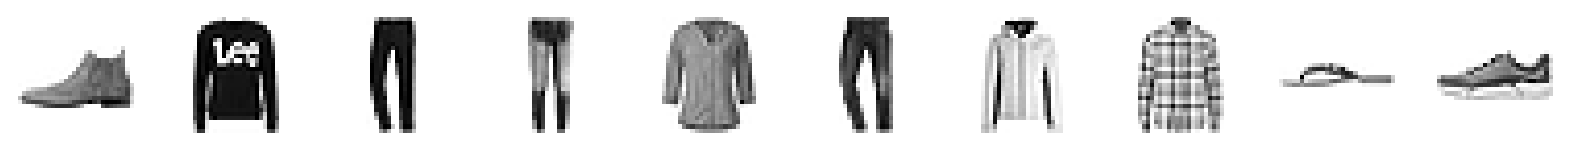

Reconstructions


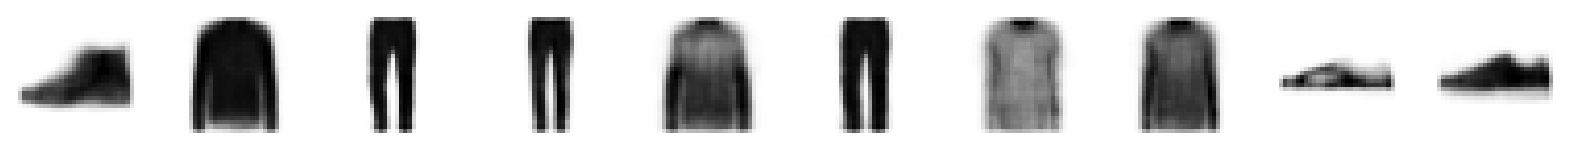

In [10]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")
        

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()
    
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]


z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

# 5 - Embeds

157/157 [==============================] - 1s 4ms/step
[[ 1.1790074  -0.81991065]
 [ 0.08432706  1.1828238 ]
 [-3.0623398   0.78408295]
 [-2.273517   -0.3454281 ]
 [-0.04808772  0.46365172]
 [-1.9877386   0.7993187 ]
 [-0.48318875 -0.34206578]
 [-0.24040723  0.07574733]
 [-0.0889736  -2.4453022 ]
 [ 0.44642407 -1.5976652 ]]


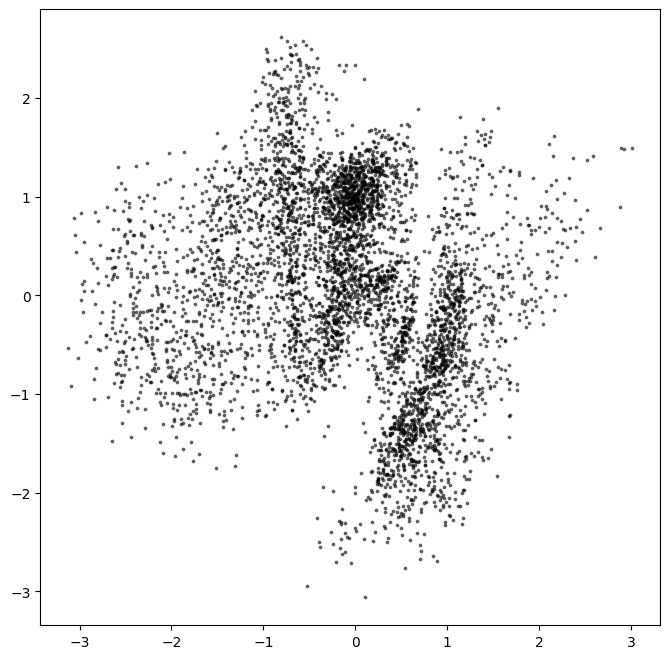

In [11]:
z_mean, z_var, z = encoder.predict(example_images)
print(z[:10])

figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

# 6 - Generation

1/1 [==============================] - 0s 51ms/step


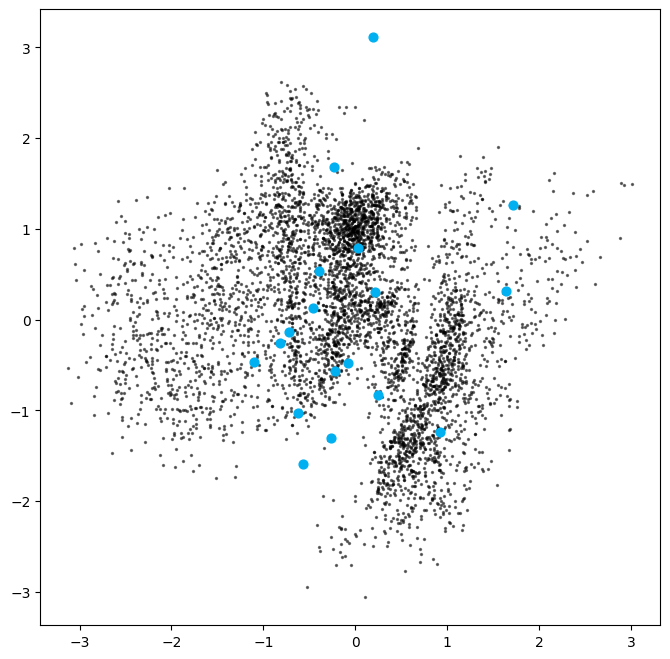

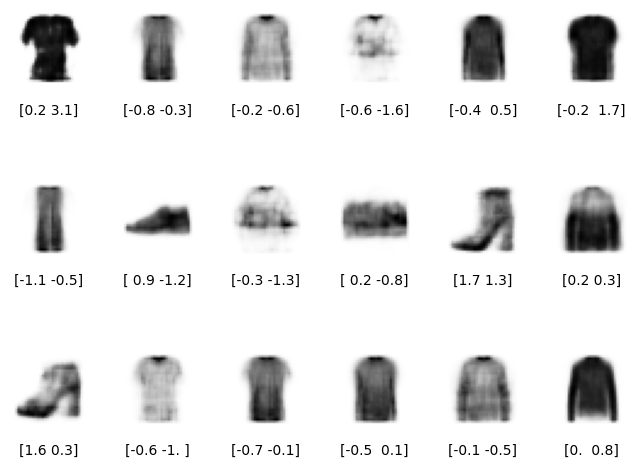

In [14]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

reconstructions = decoder.predict(z_sample)

# Fonction de répartition
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

# drawing
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# 7 - Exploration de l'espace latent

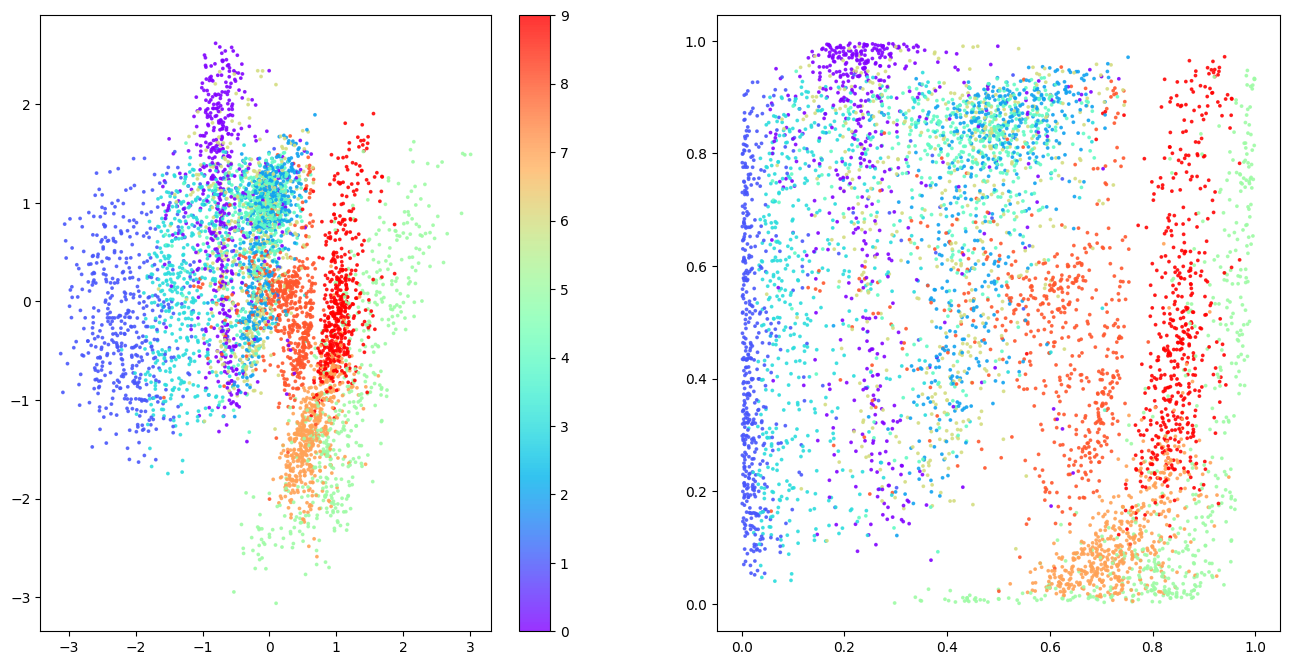

In [17]:
# Colour the embeddings by their label 
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 [==============================] - 0s 19ms/step


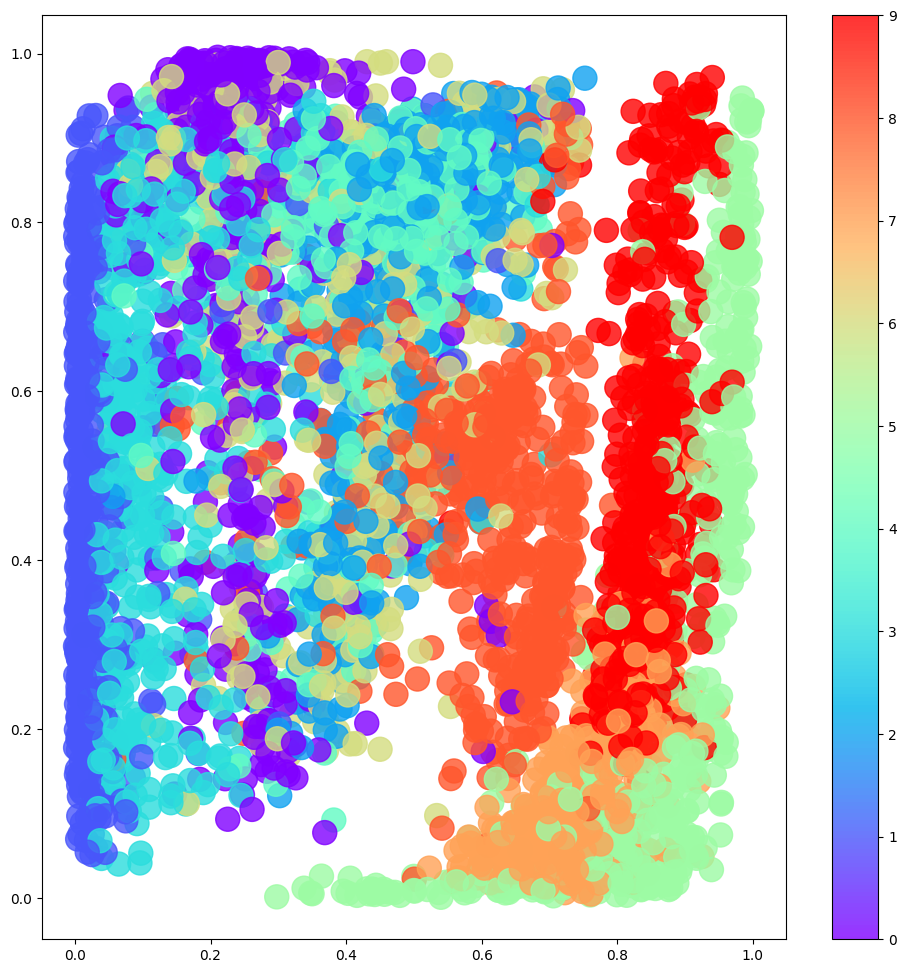

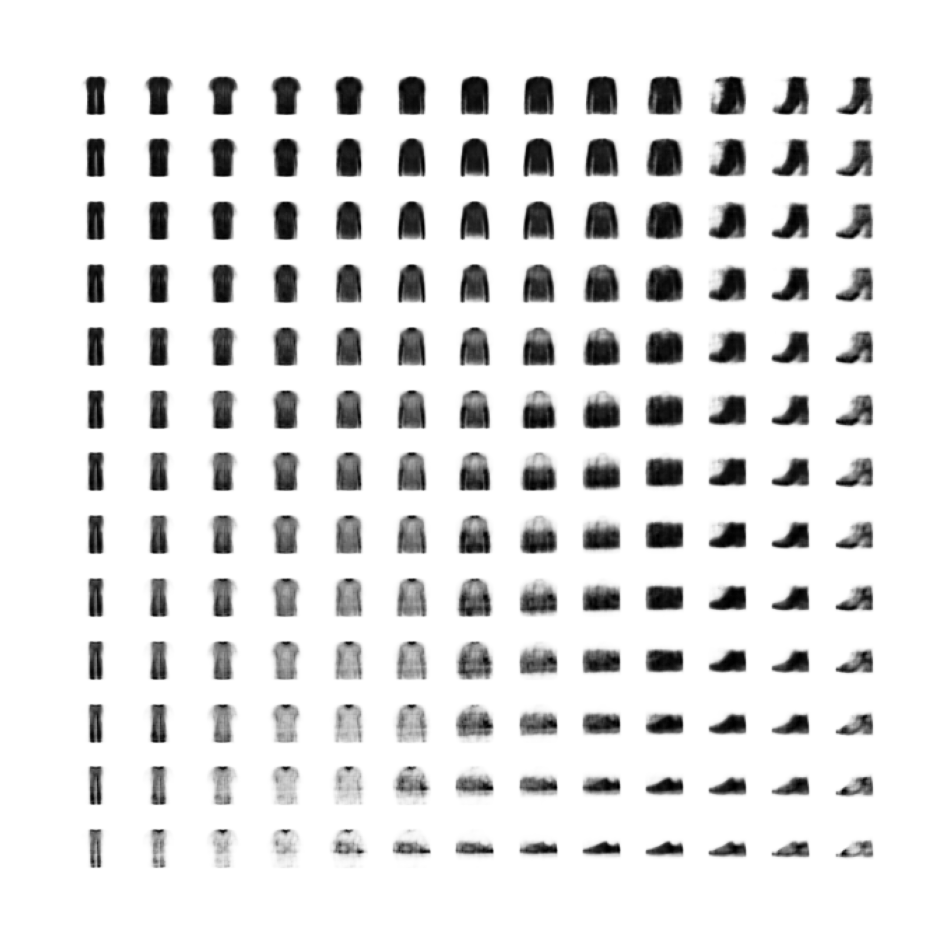

In [19]:
# Colour the embeddings by their label 
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")